In [1]:
import dill
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.transforms as transforms
from matplotlib.backends.backend_pdf import PdfPages
import numpy as np

from scipy.stats import linregress

import trompy as tp

%matplotlib inline

In [2]:
# fig settings
scattersize=50
colors = ['darkturquoise','dodgerblue', 'darkblue']

In [3]:
datafolder = "C:\\Github\\Distraction-Paper\\data\\"
figfolder = "C:\\Github\\Distraction-Paper\\figs\\"
outputfolder = "C:\\Github\\Distraction-Paper\\output\\"

try:
    pickle_in = open(datafolder + "distraction_data_only_snips.pickle", 'rb')
except FileNotFoundError:
        print('Cannot access pickled file')

[modDict, disDict, habDict] = dill.load(pickle_in)



In [4]:
# thph2.8 removed from analysis because no data on habituation day

modDict.pop('thph2.8')
disDict.pop('thph2.8')
;

''

In [5]:
d = disDict["thph2.2"]["trialtype"]

In [6]:
modalitykey = {'whitenoise':[1,4], 'tone':[2,5], 'combined3':[3,6]}


def get_trialtype_prob(daydict):
    """ Gets probility of being distracted divided into different trial types"""
    wn_prob, tone_prob, combined_prob = [], [], []

    rats = daydict.keys()
    for rat in rats:
        d = daydict[rat]

        wn = [L for L, tt in zip(d["d_bool_array"], d["trialtype"]) if (tt in [1,4])]
        wn_prob.append(sum(wn)/len(wn))

        tn = [L for L, tt in zip(d["d_bool_array"], d["trialtype"]) if (tt in [2,5])]
        tone_prob.append(sum(tn)/len(tn))

        comb = [L for L, tt in zip(d["d_bool_array"], d["trialtype"]) if (tt in [3,6])]
        combined_prob.append(sum(comb)/len(comb))
        
    return wn_prob, tone_prob, combined_prob

wn_prob, tone_prob, combined_prob = get_trialtype_prob(disDict)


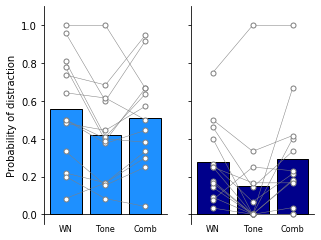

In [9]:

f, [ax1, ax2] = plt.subplots(ncols=2, figsize=(5,4), sharey=True)
f.subplots_adjust(left=0.15)

wn_prob, tone_prob, combined_prob = get_trialtype_prob(disDict)

tp.barscatter([wn_prob, tone_prob, combined_prob], paired=True,
              barfacecolor=[colors[1]], barfacecoloroption='same',
              barlabels=['WN', 'Tone', 'Comb'],
              barlabeloffset=0,
              scattersize=scattersize,
              ax=ax1)

wn_prob, tone_prob, combined_prob = get_trialtype_prob(habDict)

tp.barscatter([wn_prob, tone_prob, combined_prob], paired=True,
              barfacecolor=[colors[2]], barfacecoloroption='same',
              barlabels=['WN', 'Tone', 'Comb'],
              barlabeloffset=0,
              scattersize=scattersize,
              ax=ax2)

ax1.set_ylabel("Probability of distraction")
ax1.set_ylim([-0.05, 1.1])

f.savefig(figfolder + "trialtype_bar.pdf")